In [7]:
import numpy as np

a = [[1,2,4,5], [6,7,8,9], [1,1,1,1], [2,2,2,2]]


# a = a[0:2,0:2]

# print(a[0:2,0:2])

In [8]:
a = np.array([[[4, 9, 2], [5, 6,2], [2, 4, 5]]])
filter = np.array([[[1,0,-1],[1,0,-1],[1,0,-1]]])

In [9]:
print(a.shape)
print(a[0:2,0:2])
# a[0:2,0:2]=np.zeros(2)

print("****************")
print(filter[0,1,0])
print(a*filter[0,1,0])
print("****************")
print(np.sum(a*filter, axis=(1,2)))
print("****************")
out_p = np.array([0,1,2,3,4,5,6,7,8,9])
print(-np.log(out_p[1:]))
print(np.argmax(out_p))
print("****************")

print(np.dot(a,filter))
print("****************")
print(a[:,:])
print(np.amax(a, axis = (1,2)))

(1, 3, 3)
[[[4 9 2]
  [5 6 2]]]
****************
1
[[[4 9 2]
  [5 6 2]
  [2 4 5]]]
****************
[2]
****************
[-0.         -0.69314718 -1.09861229 -1.38629436 -1.60943791 -1.79175947
 -1.94591015 -2.07944154 -2.19722458]
9
****************
[[[[ 15   0 -15]]

  [[ 13   0 -13]]

  [[ 11   0 -11]]]]
****************
[[[4 9 2]
  [5 6 2]
  [2 4 5]]]
[9]


In [10]:
# !pip install -q git+https://github.com/tensorflow/examples.git

In [11]:
import numpy as np
from numpy import asarray
import cv2
import matplotlib.pyplot as plt
# from tensorflow.examples.tutorials.mnist import input_data


import tensorflow_datasets
mnist = tensorflow_datasets.load('mnist')



class Conv_op:
    def __init__(self, num_filters, filter_size):
        self.num_filters =  num_filters
        self.filter_size = filter_size
        self.conv_filter = np.random.randn (num_filters, filter_size, filter_size)/(filter_size* filter_size)

    def image_region(self, image):

        height, width = image.shape
        self.image = image
        for j in range(height- self.filter_size + 1 ):
            for k in range(width - self.filter_size + 1):
                image_patch = image[j : (j + self.filter_size), k:( k + self.filter_size)]
                yield image_patch, j, k

    def forward_prop(self, image):
        height, width = image.shape
        conv_out = np.zeros((height - self.filter_size + 1, width - self.filter_size + 1, self.num_filters ))

        for image_patch, i, j in self.image_region (image):
            conv_out[i,j] = np.sum (image_patch*self.conv_filter, axis = (1,2)) # the addition of (Wij * Fij)
        return conv_out

    #https://becominghuman.ai/back-propagation-in-convolutional-neural-networks-intuition-and-code-714ef1c38199
    def back_prop(self, dL_dout, learning_rate):
        dL_dF_params = np.zeros(self.conv_filter.shape)
        for image_patch, i, j in self.image_region(self.image):
            for k in range(self.num_filters):
                dL_dF_params[k] += image_patch*dL_dout[i,j,k]

        # Filter params update
        self.conv_filter -= learning_rate*dL_dF_params
        return dL_dF_params


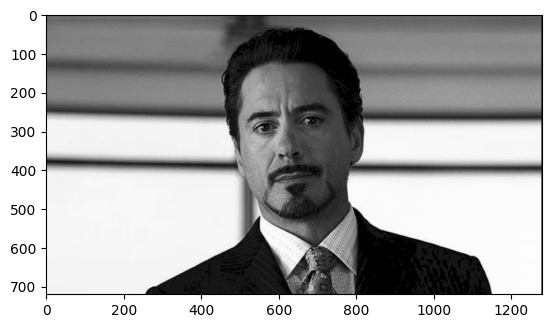

(720, 1280)

In [12]:
image = cv2.imread('download.png', cv2.IMREAD_GRAYSCALE)/255
plt.imshow(image, cmap= 'gray')
plt.show()
image.shape


In [39]:
conn = Conv_op(18,7)
out = conn.forward_prop(image)
out.shape

(714, 1274, 18)

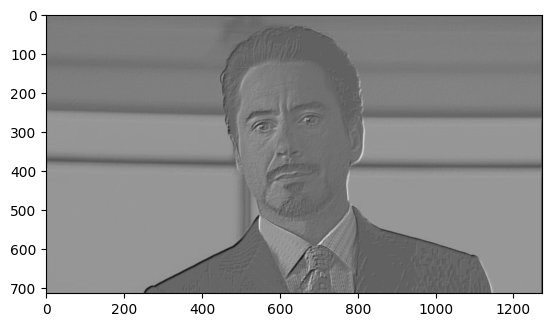

In [42]:
plt.imshow(out[:,:,15], cmap= 'gray')
plt.show()

In [15]:
class Max_Pool:
  def __init__(self, filter_size):
      self.filter_size = filter_size

  def image_region(self, image):
      new_height = image.shape[0] // self.filter_size
      new_width  = image.shape[1] // self.filter_size
      self.image = image

      for i in range(new_height):
        for j in range(new_width):
          image_patch = image[(i*self.filter_size) : (i*self.filter_size + self.filter_size) , (j*self.filter_size) : (j*self.filter_size + self.filter_size)]
          yield image_patch, i, j


  def forward_prop(self, image):
    height, width , num_filters = image.shape
    output = np.zeros((height // self.filter_size, width // self.filter_size, num_filters))

    for image_patch , i , j in self.image_region(image):
      output[i,j] = np.amax(image_patch, axis = (0,1))

    return output

  def back_prop (self, dL_dout):
    dL_dmax_pool = np.zeros(self.image.shape)
    for image_patch, i, j in self.image_region(self.image):
      height, width, num_filters = image_patch.shape
      maximum_val = np.amax(image_patch, axis= (0,1))

      for i1 in range(height):
         for j1 in range(width):
             for k1 in range(num_filters):
                if image_patch[i1, j1, k1] == maximum_val[k1]:
                   dL_dmax_pool[i*self.filter_size + i1, j*self.filter_size + j1, k1] = dL_dout[i,j,k1]

      return dL_dmax_pool





In [16]:
conn2 = Max_Pool(4)
out2 = conn2.forward_prop(out)
out2.shape

(178, 318, 18)

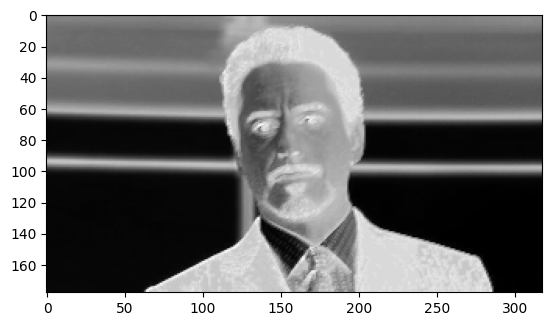

In [35]:
plt.imshow(out2[:,:,0], cmap = 'gray')
plt.show()

In [18]:
class Softmax:
  def __init__(self, input_node, softmax_node):
     self.weight = np.random.randn(input_node, softmax_node) / input_node
     self.bias = np.zeros(softmax_node)

  def forward_prop(self, image):

    self.orig_im_shape = image.shape  # used in backprop
    image_modified = image.flatten()
    self.modified_input = image_modified  # to be used in backprop
    output_val = np.dot(image_modified, self.weight) + self.bias
    self.out = output_val
    exp_out = np.exp(output_val)
    return exp_out / np.sum(exp_out, axis = 0)

  def back_prop(self, dL_dout, learning_rate):
        for i, grad in enumerate(dL_dout):
            if grad == 0:
                continue
                # Rest of the code for handling non-zero gradients
            transformation_eq = np.exp(self.out)
            S_total = np.sum(transformation_eq)

            # Gradients with respect to out (z)
            dy_dz = -transformation_eq[i]*transformation_eq / (S_total **2)                  #case: i!=l
            dy_dz[i] = transformation_eq[i]*(S_total - transformation_eq[i]) / (S_total **2) #case: i=l

            # Gradients of totals against weights/biases/input
            dz_dw = self.modified_input
            dz_db = 1
            dz_d_inp = self.weight

            # Gradients of loss against totals
            dL_dz = grad * dy_dz

            # Gradients of loss against weights/biases/input
            '''
            This line is performing matrix multiplication between the transposed version of dz_dw[np.newaxis]
            and dL_dz[np.newaxis].
            Here's a breakdown:
            dz_dw[np.newaxis] creates a new axis along the first dimension, effectively turning it into a row vector.
            .T transposes this row vector, making it a column vector.
            @ performs matrix multiplication between the transposed dz_dw and dL_dz.
            '''
            dL_dw = dz_dw[np.newaxis].T @ dL_dz[np.newaxis]  #the expression A @ B is equivalent to np.matmul(A, B) in NumPy, and it performs matrix multiplication.
            dL_db = dL_dz * dz_db
            dL_d_inp = dz_d_inp @ dL_dz

            # Update weights and biases
            self.weight -= learning_rate * dL_dw
            self.bias -= learning_rate * dL_db
            return dL_d_inp.reshape(self.orig_im_shape)


In [20]:
conn3 = Softmax(178*318*18, 10)
out3 = conn3.forward_prop(out2)
print(out3)

[0.0999975  0.09999601 0.10000019 0.10000445 0.09999541 0.10000304
 0.09999442 0.10000072 0.10000317 0.10000509]


In [21]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

train_images = X_train[:1500]
train_labels = y_train[:1500]
test_images = X_test[:1500]
test_labels = y_test[:1500]

conv = Conv_op(8,3)                              #28x28x1 -> 26x26x8
pool = Max_Pool(2)                               #26x26x8 -> 13x13x8
softmax = Softmax(13 * 13 * 8, 10)               #13x13x8 -> 10 (we choosed 10 because we have 10 classes represent digits from 0 to 9)

def cnn_forward_prop(image, label):

  out_p = conv.forward_prop((image / 255) - 0.5)
  out_p = pool.forward_prop(out_p)
  out_p = softmax.forward_prop(out_p)

  # Calculate cross-entropy loss and accuracy
  cross_ent_loss = -np.log(out_p[label])
  accuracy_eval = 1 if np.argmax(out_p) == label else 0

  return out_p, cross_ent_loss, accuracy_eval


11490434/11490434 [==============================] - 0s 0us/step


In [22]:
#cnn back propagation
def training_cnn(image, label, learn_rate=.005):
  # Forward
  out, loss, acc = cnn_forward_prop(image, label)
  # Calculate initial gradient
  gradient = np.zeros(10)
  gradient[label] = -1 / out[label]
  # Backprop
  grad_back = softmax.back_prop(gradient, learn_rate)
  grad_back = pool.back_prop(grad_back)
  grad_back = conv.back_prop(grad_back, learn_rate)

  return loss, acc


In [23]:
for epoch1 in range(4):
  print('Epoch %d --->' % (epoch1 + 1))

  #Shuffle the training data
  shuffle_data = np.random.permutation(len(train_images))
  train_images = train_images[shuffle_data]
  train_labels = train_labels[shuffle_data]

  # Training the CNN
  loss = 0
  num_correct = 0
  for i, (im, label) in enumerate(zip(train_images, train_labels)):
    if i % 100 == 0:
      print('%d steps out of 100 steps: Average Loss %.3f and Accuracy: %d%%' %(i + 1, loss / 100, num_correct))
      loss = 0
      num_correct = 0

    l1, accu = training_cnn(im, label)
    loss += l1
    num_correct += accu


Epoch 1 --->
1 steps out of 100 steps: Average Loss 0.000 and Accuracy: 0%
101 steps out of 100 steps: Average Loss 2.219 and Accuracy: 25%
201 steps out of 100 steps: Average Loss 2.083 and Accuracy: 37%
301 steps out of 100 steps: Average Loss 1.896 and Accuracy: 53%
401 steps out of 100 steps: Average Loss 1.729 and Accuracy: 58%
501 steps out of 100 steps: Average Loss 1.631 and Accuracy: 65%
601 steps out of 100 steps: Average Loss 1.567 and Accuracy: 72%
701 steps out of 100 steps: Average Loss 1.456 and Accuracy: 68%
801 steps out of 100 steps: Average Loss 1.394 and Accuracy: 76%
901 steps out of 100 steps: Average Loss 1.288 and Accuracy: 76%
1001 steps out of 100 steps: Average Loss 1.262 and Accuracy: 83%
1101 steps out of 100 steps: Average Loss 1.118 and Accuracy: 82%
1201 steps out of 100 steps: Average Loss 1.324 and Accuracy: 67%
1301 steps out of 100 steps: Average Loss 0.981 and Accuracy: 82%
1401 steps out of 100 steps: Average Loss 1.054 and Accuracy: 79%
Epoch 2 --

In [ ]:
# Testing the CNN print('**Testing phase')
loss = 0
num_correct = 0
for im, label in zip(test_images, test_labels):
  _,ll, accu = cnn_forward_prop(im, label)
  loss += ll
  num_correct += accu

num_tests = len(test_images)
print('Test Loss:', loss / num_tests)
print('Test Accuracy:', num_correct / num_tests)


Test Loss: 0.7031414122674075
Test Accuracy: 0.8146666666666667
